<a href="https://colab.research.google.com/github/Vikas-Kumar05/tumor_detection_from_MRI_images_using_hydrid_cnn_model/blob/main/tumor_detection_from_mri_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Params
EPOCHS = 50 #used epochs= 16
BATCH_SIZE = 32
SHUFFLE = True
IMAGE_SIZE = (150, 150)

# Data Loading

In [ ]:
# Ignoring warnings
import warnings
warnings.simplefilter("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for testing data, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Data paths
train_dir = '/content/drive/MyDrive/Research paper study/cnn project/Training'
test_dir = '/content/drive/MyDrive/Research paper study/cnn project/Testing'

# Training data
BATCH_SIZE = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=SHUFFLE
)

# Testing data
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=SHUFFLE
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence

class MultiInputDataGenerator(Sequence):
    def __init__(self, generator, batch_size):
        self.generator = generator
        self.batch_size = batch_size

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        batch_x, batch_y = self.generator[index]
        return (batch_x, batch_x), batch_y

    def on_epoch_end(self):
        self.generator.on_epoch_end()

# Custom data generators for dual input
train_multi_input_gen = MultiInputDataGenerator(train_generator, batch_size=BATCH_SIZE)
val_multi_input_gen = MultiInputDataGenerator(validation_generator, batch_size=BATCH_SIZE)

# Data Analysis

In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Function to count files in each directory
def count_files(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        class_counts[class_dir] = len(os.listdir(class_path))
    return class_counts

# Count files in training and testing directories
train_counts = count_files(train_dir)
test_counts = count_files(test_dir)

# Plotting class distributions with Pie charts
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Training Data Class Distribution', 'Testing Data Class Distribution'])

fig.add_trace(go.Pie(labels=list(train_counts.keys()), values=list(train_counts.values()), name="Training"),
              1, 1)
fig.add_trace(go.Pie(labels=list(test_counts.keys()), values=list(test_counts.values()), name="Testing"),
              1, 2)
fig.show()

In [ ]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Function to get image sizes
def get_image_sizes(directory):
    sizes = []
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            with Image.open(img_path) as img:
                sizes.append(img.size)
    return sizes

# Get image sizes
train_sizes = get_image_sizes(train_dir)
test_sizes = get_image_sizes(test_dir)

In [ ]:
import plotly.express as px

# Convert to DataFrame for easy plotting
train_sizes_df = pd.DataFrame(train_sizes, columns=['Width', 'Height'])
test_sizes_df = pd.DataFrame(test_sizes, columns=['Width', 'Height'])

# Plotting image sizes using Plotly
fig_train = px.scatter(train_sizes_df, x='Width', y='Height', title='Training Data Image Sizes')
fig_train.update_layout(width=800)
fig_train.show()

fig_test = px.scatter(test_sizes_df, x='Width', y='Height', title='Testing Data Image Sizes')
fig_test.update_layout(width=800)
fig_test.show()

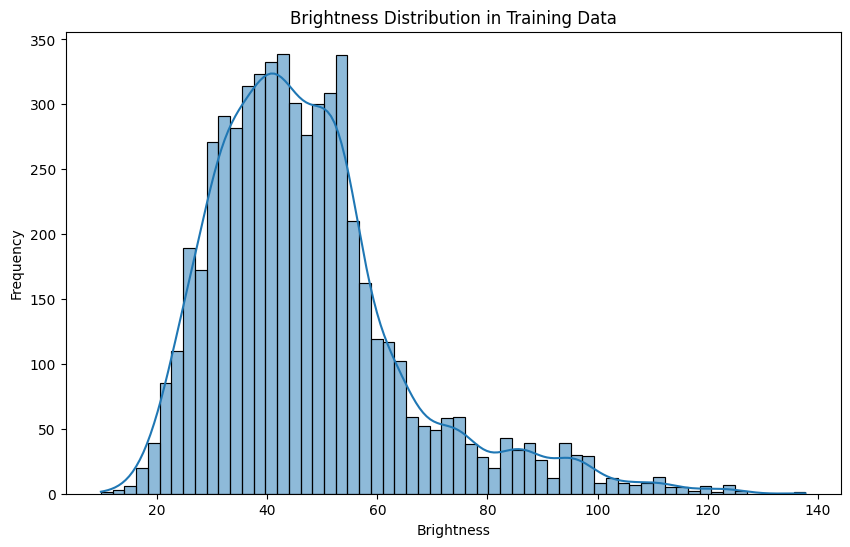

In [ ]:
# Function to calculate image birghtness
def calculate_brightness(image):
    img = np.array(image)
    return np.mean(img)

# Analyze brightness
train_brightness = []
for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        with Image.open(img_path) as img:
            train_brightness.append(calculate_brightness(img))

# Plot brightness distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_brightness, kde=True)
plt.title('Brightness Distribution in Training Data')
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Check normalization
batch = next(train_generator)
print(f'Batch shape: {batch[0].shape}')
print(f'Min pixel value: {batch[0].min()}')
print(f'Max pixel value: {batch[0].max()}')

# Ensure labels are encoded correctly
print(f'Class indices: {train_generator.class_indices}')

# Get file paths and labels
train_file_paths = []
train_labels = []
for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)
    for img_name in os.listdir(class_path):
        train_file_paths.append(os.path.join(class_path, img_name))
        train_labels.append(class_dir)

# Class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print(f'Class weights: {class_weights}')

Batch shape: (32, 150, 150, 3)
Min pixel value: 0.0
Max pixel value: 1.0
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Class weights: {0: 1.080999242997729, 1: 1.0664675130694548, 2: 0.8952978056426333, 3: 0.9800960878517502}


# Modeling

## a) Model Designing

In [ ]:
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, concatenate, BatchNormalization, GlobalAveragePooling2D

def create_pretrained_model_1(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers[:10]:
        layer.trainable = True

    for layer in base_model.layers[10:]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    return base_model.input, x

def create_pretrained_model_2(input_shape):

    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers[:10]:
        layer.trainable = True

    for layer in base_model.layers[10:]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)
    return base_model.input, x

def create_hybrid_model(input_shape):
    input_1, output_1 = create_pretrained_model_1(input_shape)
    input_2, output_2 = create_pretrained_model_2(input_shape)

    combined = concatenate([output_1, output_2])
    z = Dense(256, activation='relu')(combined)
    z = Dropout(0.6)(z)
    z = Dense(4, activation='softmax')(z)

    model = Model(inputs=[input_1, input_2], outputs=z)
    return model

input_shape = (150, 150, 3)
hybrid_model = create_hybrid_model(input_shape)
hybrid_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 74, 74, 32)           864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d_4[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)   

In [ ]:
# Compile the model
# hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hybrid_model = create_hybrid_model((150, 150, 3))
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## b) Model Training

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks = [checkpoint, early_stopping]

In [ ]:
# Train the model
history = hybrid_model.fit(
    train_multi_input_gen,
#     steps_per_epoch=len(train_multi_input_gen),
    validation_data=val_multi_input_gen,
#     validation_steps=len(val_multi_input_gen),
    epochs=16,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/16
179/179 [==============================] - 500s 3s/step - loss: 0.9470 - accuracy: 0.6558 - val_loss: 0.6707 - val_accuracy: 0.7361
Epoch 2/16
179/179 [==============================] - 477s 3s/step - loss: 0.6078 - accuracy: 0.7701 - val_loss: 0.4725 - val_accuracy: 0.8200
Epoch 3/16
179/179 [==============================] - 475s 3s/step - loss: 0.5024 - accuracy: 0.8116 - val_loss: 0.3896 - val_accuracy: 0.8467
Epoch 4/16
179/179 [==============================] - 474s 3s/step - loss: 0.4569 - accuracy: 0.8342 - val_loss: 0.5897 - val_accuracy: 0.7879
Epoch 5/16
179/179 [==============================] - 473s 3s/step - loss: 0.4391 - accuracy: 0.8396 - val_loss: 0.4290 - val_accuracy: 0.8337
Epoch 6/16
179/179 [==============================] - 474s 3s/step - loss: 0.3989 - accuracy: 0.8571 - val_loss: 0.3484 - val_accuracy: 0.8619
Epoch 7/16
179/179 [==============================] - 471s 3s/step - loss: 0.3934 - accuracy: 0.8633 - val_loss: 0.3740 - val_accuracy: 0.8589

In [ ]:
# Saving final model
hybrid_model.save("trained_model.keras")

## c) Model Evaluation

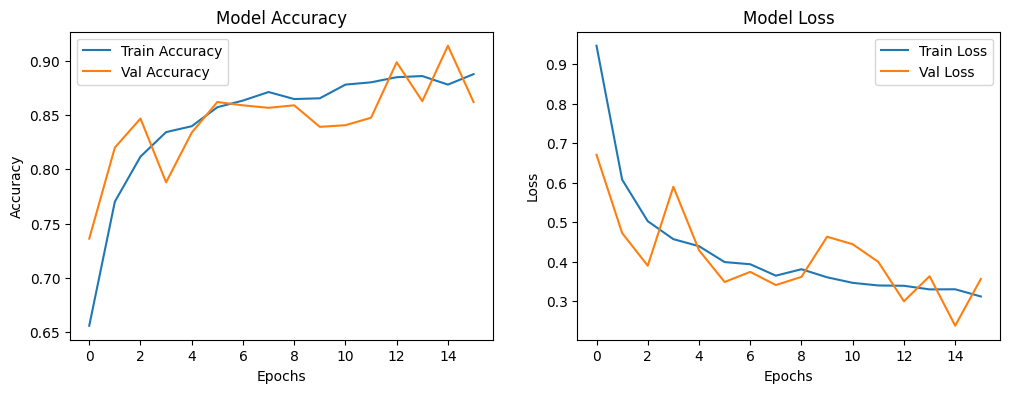

In [ ]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Reset the validation generator
val_multi_input_gen.on_epoch_end()

# Initialize lists to store validation images and labels
val_images_all = []
val_labels_all = []

# Fetch all validation data
for i in range(len(val_multi_input_gen)):
    (val_images, _), val_labels = val_multi_input_gen[i]
    val_images_all.append(val_images)
    val_labels_all.append(val_labels)

# Convert lists to numpy arrays
val_images_all = np.vstack(val_images_all)
val_labels_all = np.vstack(val_labels_all)

# Make predictions
val_preds = hybrid_model.predict([val_images_all, val_images_all])
val_preds_classes = np.argmax(val_preds, axis=1)
val_true_classes = np.argmax(val_labels_all, axis=1)

# Calculate metrics
accuracy = accuracy_score(val_true_classes, val_preds_classes)
precision = precision_score(val_true_classes, val_preds_classes, average='weighted')
recall = recall_score(val_true_classes, val_preds_classes, average='weighted')
f1 = f1_score(val_true_classes, val_preds_classes, average='weighted')
class_report = classification_report(val_true_classes, val_preds_classes, target_names=train_generator.class_indices.keys())
conf_matrix = confusion_matrix(val_true_classes, val_preds_classes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('Classification Report:')
print(class_report)
print('Confusion Matrix:')
print(conf_matrix)

41/41 [==============================] - 15s 310ms/step
Accuracy: 0.8619374523264683
Precision: 0.8711288630073983
Recall: 0.8619374523264683
F1 Score: 0.8580476243707521
Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.79      0.87       300
  meningioma       0.84      0.65      0.73       306
     notumor       0.91      0.98      0.95       405
   pituitary       0.76      0.98      0.86       300

    accuracy                           0.86      1311
   macro avg       0.87      0.85      0.85      1311
weighted avg       0.87      0.86      0.86      1311

Confusion Matrix:
[[237  35   2  26]
 [  5 200  34  67]
 [  1   4 398   2]
 [  2   0   3 295]]


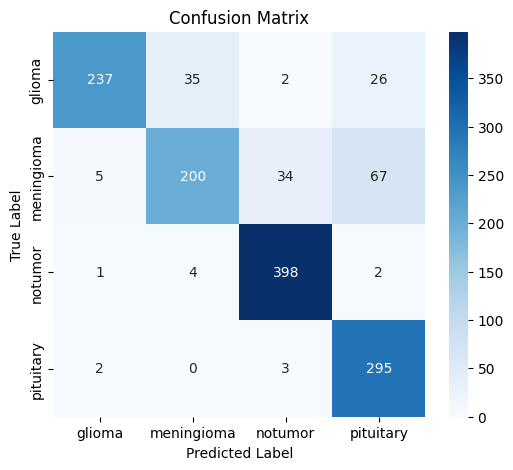

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(conf_matrix, list(train_generator.class_indices.keys()))

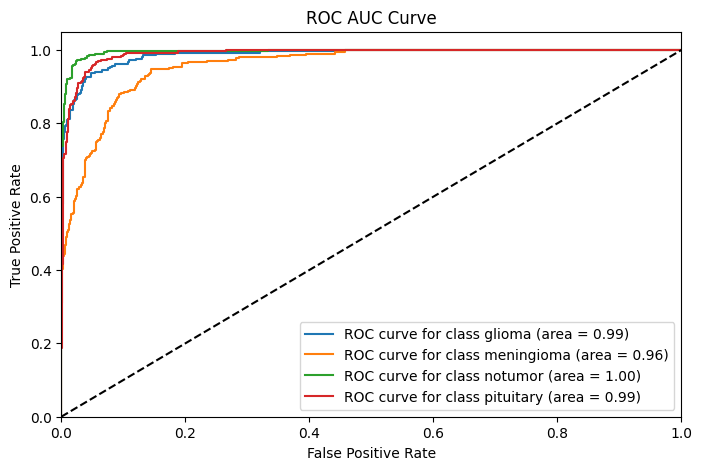

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true classes for ROC curve
val_labels_binarized = label_binarize(val_true_classes, classes=[0, 1, 2, 3])

# Plot ROC AUC curve
def plot_roc_auc_curve(y_true, y_pred, classes):
    plt.figure(figsize=(8, 5))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve for class {classes[i]} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_auc_curve(val_labels_binarized, val_preds, list(train_generator.class_indices.keys()))

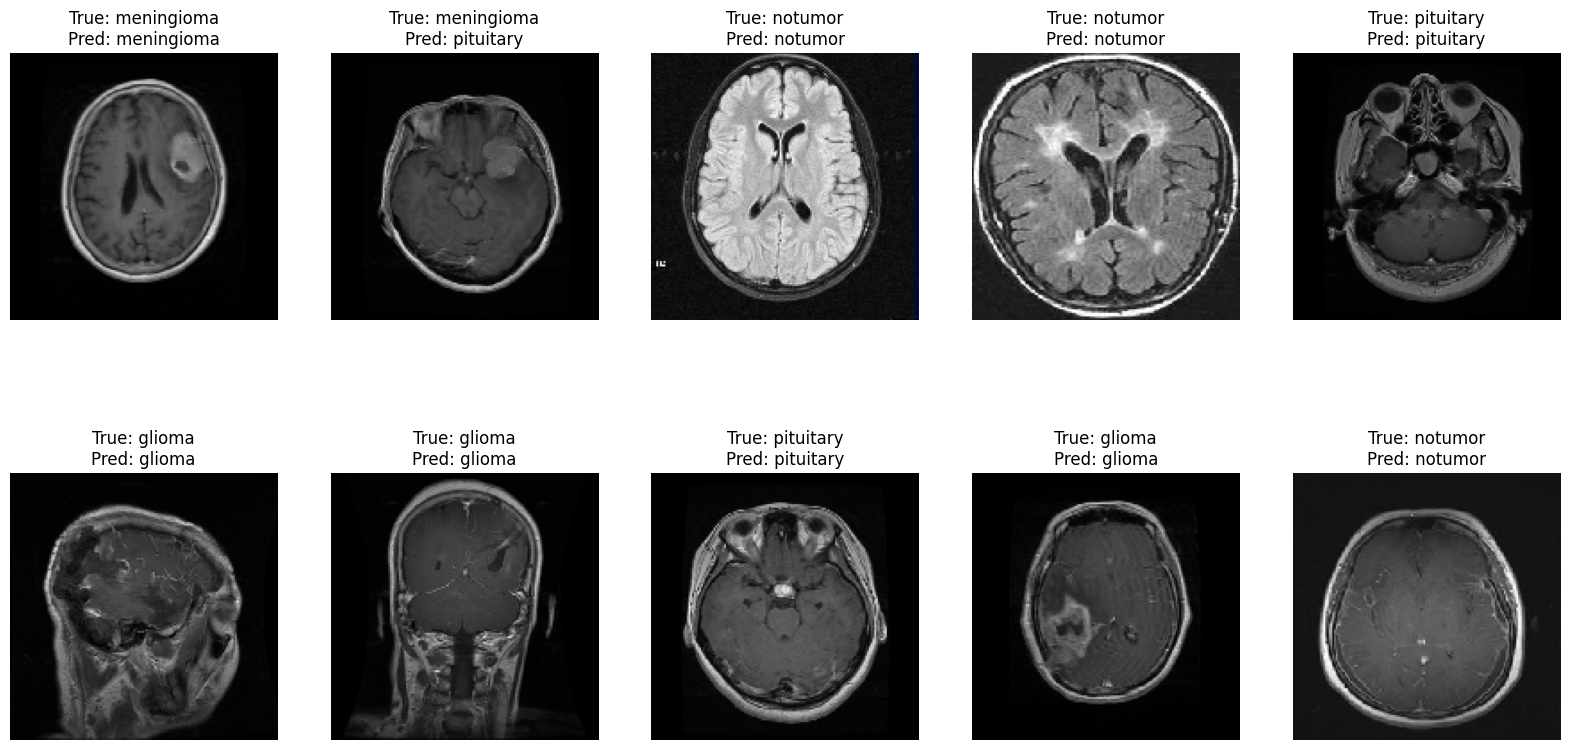

In [ ]:
import random

# Plot random samples with actual and predicted labels
def plot_random_samples(images, true_labels, pred_labels, class_names, n=10):
    plt.figure(figsize=(20, 10))
    indices = random.sample(range(len(images)), n)
    for i, idx in enumerate(indices):
        plt.subplot(2, n//2, i+1)
        plt.imshow(images[idx])
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[pred_labels[idx]]
        plt.title(f'True: {true_class}\nPred: {pred_class}')
        plt.axis('off')
    plt.show()

class_names = list(train_generator.class_indices.keys())
plot_random_samples(val_images_all, val_true_classes, val_preds_classes, class_names)

In [ ]:
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']